Cargamos las librerías, el conjunto de datos y algunas variables que emplearemos durante el proceso:

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pickle
%matplotlib inline

import xgboost as xgb

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

df = pickle.load(open('./processed_data/houses_cleaned.p',"rb"))

# Omitimos los warnings
import warnings
warnings.filterwarnings('ignore')

# XG-Boost

En esta última fase del análisisá implementaremos un modelo de regresión con el que trataremos de predecir los precios de las viviendas. Para ello, nos valdremos de la técnica potenciación del gradiente (*Gradient Boosting*), la cual sirve para generar un modelo predictivo de gran precisión mediante la suma de muchos modelos de predicción debiles. En nuestro caso, estos modelos débiles serán árboles de decisión.

Más concretatemente, emplearemos una implementación de esta técnica llamada **XG-Boost**, *eXtreme Gradient Boosting*, la cual se ha convertido, gracias a su eficiencia y eficacia, en uno de los modelos más empleados en la actualidad para lidiar con problemas de regresión y clasificación relacionados con datos tabulares, como en este caso.

Este gran rendimiento viene dado, entre otros factores, por el amplio abaníco de hiperparámetros que contiene. Estos hiperparámetros, permiten un ajuste minucioso, y con una buena afinación, permiten optimizar y mejorar el resultado de forma considerable. No obstante, esta afinación no es trivial, por lo que, para conseguir buenos resultados, es necesaria una cuidadosa estrategia de hiperparametrización.

Así, dado que gran parte de la implementación del modelo recae sobre esta búsqueda, conviene realizar una breve descripción inicial acerca de cuáles son estos hiperparámetros, y de qué modo afectan a nuestro modelo.

## Hiperparámetros de XG-Boost

+ __<font color=#5F66A1>n_estimators</font>__:

Con este hiperparámetro indicaremos cuántos árboles queremos exactamente que se construyan, lo cual jugará un papel fundamental en el aprendizaje de nuestro modelo. Porque, con cada nuevo árbol, XG-Boost tratará de minimizar la función de coste que le hayamos asignado (RMSE en este caso). Así, cuanto mayor sea el número de árboles que empleemos, más estaremos minimizado nuestro error...

...no obstante, es necesario subrayar aquí que el error que XG-Boost minimizará será el error del conjunto de entrenamiento. Es decir, el modelo aprenderá a predecir cada vez más certeramente el precio de aquellas viviendas con las que se entrene. Pero el hecho de que aprenda a predecir cada vez mejor los precios de estas casas, no siempre conlleva que aprenda a hacer lo propio con otras viviendas. Es más, lo que sucederá es que, a partir de un cierto número de árboles, el modelo se sobrespecializará tanto (*overfitting*) en los datos de entrenamiento que ya no sabrá generalizar este conocimiento Así que, empezará a predecir cada vez peor el precio del resto de casas. Por ello, la clave, aquí, será ajustar este hiperparámetro hasta encontrar ese punto en el cual se consigue un modelo complejo, pero que además es capaz de generalizar. Para ello, nos valdremos del hiperparámetro que se muestra a continuación:

+ __<font color=#5F66A1>early_stopping</font>__:

Para poder utilizar este hiperparámetro tendremos que dividir el conjunto de entrenamiento en 2 nuevos subconjuntos: uno lo usaremos para entrenar el modelo, y otro lo usaremos para evaluar las predicciones.

De este modo, para cada árbol nuevo que añadamos, emplearemos ahora ese nuevo subconjunto de validación para ver si su error incrementa o no. Y, dado que el modelo no busca explícitamente reducir el error de los datos de validación, sino el de los de entrenamiento, podemos inferir que, si el error de validación ya no decrece sino que aumenta, es porque el modelo está empezando ya a sobrespecializarse. Por lo tanto, en el momento en el que detectemos este punto de inflexión, podemos detener la creación de más árboles nuevos.

Sin embargo, dado que, precisamente, el modelo no busca minimizar el error del conjunto de validación, puede ocurrir que se de un pequeño paso en falso en algún momento que haga aumentar por un momento el error, pero que no por ello hayamos llegado al punto donde empieza a generarse *overfitting*. Es más, estos pequeños pasos en falso son muy habituales a partir de cierto punto. Por lo tanto, un enfoque mejor que el de parar el crecimiento al primer indicio de retroceso, puede ser el detenerse solo tras un cierto número de pasos en falso consecutivos. Y eso es para lo que sirve exactamente este hiperparámetro; para controlar cuántos pasos en falso podemos dar antes de considerar que la tendencia no es reversible y que es mejor dejar de generar más árboles. Así, cuanto mayor sea su valor, más tolerancia estaremos otorgando al modelo para cometer pasos en falso.

+ __<font color=#5F66A1>eval_metric</font>__:


+ __<font color=#5F66A1>learning_rate</font>__:

Hemos mencionado ya que XG-Boost irá generando nuevos modelos mediante los cuales buscará minimiza el error (error cuadrático medio en nuestro caso). Sin embargo, hasta ahora no habíamos hablado de la velocidad con la que XG-Boost trata de acercarse a este mínimo. Este hiperparámetro sirve precisamente para eso, controlar esta tasa de aprendizaje.

Así, cuanto mayor sea la tasa, más rápido se tratará de alcanzar ese mínimo. Sin embargo, estos grandes cambios pueden provocar que quizás nunca se llegue a converger. En el otro lado de la moneda, si la tasa es pequeña, el modelo se acercará más lentamente, tardará más, pero tal vez encuentre mas facilidades a la hora de converger.

Tomando el golf como analogía, si usamos golpes largos para llegar al hoyo, con pocos golpes habremos llegado a las inmediaciones del banderín, pero una vez allí, si seguimos con esos mismos golpes no podremos introducir jamás la bola, y estaremos pasándo por encima del banderín de un lado a otro.

Si optamos por emplear golpes pequeños, sin embargo, tardaremos mucho más en llegar a las inmediaciones del banderín, pero una vez allí, tendremos la delicadeza suficiente como para no pasarnos. Con lo cual, como regla general, cuanto menor sea nuestra tasa, mas tardaremos, pero más precisos seremos en la mayoría de casos. ¿Cuando no sucede eso? Cuando, por emplear golpes pequeños, propiciamos que la bola caiga en un foso del que ya no podemos salir. Esto vendría a ejemplificar el problema de converger en un mínimo local, el cual se da, sobretodo, cuando escogemos tasas de aprendizaje demasiado bajas.

En el golf, este problema se resuelve adaptando la longitud del paso a la cercanía para con el hoyo. Si bien existen formas de emplear la misma intuición en nuestro contexto, aún no son muy empleadas, por lo que la solución pasa por saber encontrar un buen equilibrio entre llegar con una 

mediante el cual intenta  nuestro modelo. Es decir, nuestro modelo aplicarú 

+ __<font color=#5F66A1>max_depth</font>__: 
+ __<font color=#5F66A1>min_child_weight</font>__: 
+ __<font color=#5F66A1>subsample</font>__: 


+ __<font color=#5F66A1>colsample_bytree</font>__:

Recordemos que XG-Boost se compone de un gran conjunto de árboles de decisión simples. Con este hiperparámetro controlamos el porcentaje de variables que se emplearán en cada árbol. Estas variables se elegirán de forma aleatoria. El rango de valores posible va de 0 (no se usa ninguna variable) hasta 1 (cada árbol se construye con todas las variables de nuestro dataset). Cuanto mayor sea el número de variables que usemos, más complejo será nuestro modelo, lo cual podrá suponer una mejora en la calidad de nuestras predicciones, pero un aumento del riesgo de *overfitting*.

Opcional

Valores válidos: número flotante. Rango: [0,1].

Valor predeterminado: 1
+ __<font color=#5F66A1>reg_alpha</font>__:
+ __<font color=#5F66A1>gamma</font>__:

+ __<font color=#5F66A1>objective</font>__: 

# Preparación de los datos

En esta última fase del análisis implementaremos un modelo de regresión para tratar de predecir el precio de las viviendas. Para ello, antes de poder alimentar nuestro modelo, sera necesario adaptar los datos de acuerdo con las necesidades del modelo.

No obstante, antes de satisfacer estas necesidades, realizaremos una criba preliminar de los datos que disponemos, descartando todas las viviendas con precio superior a los 600.000€:

In [2]:
df6 = df.query('price < 600000')

Por otro lado, un modelo de regresión lineal requiere que las variables sean numéricas. Por lo tanto, para poder incluir variables categóricas, tenemos que realizar un **one-hot-encoding**. En nuestro conjunto de datos tenemos las siguientes variables categóricas:

+ __<font color=#5F66A1>house_type</font>__
+ __<font color=#5F66A1>condition</font>__
+ __<font color=#5F66A1>garage</font>__
+ __<font color=#5F66A1>location</font>__
+ __<font color=#5F66A1>loc_city</font>__
+ __<font color=#5F66A1>loc_zone</font>__

En el caso de las variables relacionadas con la ubicación, en realidad las 3 hacen referencia a una sola, solo que con granularidad distinta. Por ello, optaremos por quedarnos con la más específica, __<font color=#5F66A1>location</font>__, y descartaremos el resto. Con lo cual, procedemos a crear las variables *dummy*:

In [3]:
dummy_houseType = pd.get_dummies(df6['house_type'])
dummy_garage = pd.get_dummies(df6['garage'], prefix='garage')
dummy_condition = pd.get_dummies(df6['condition'])
dummy_location = pd.get_dummies(df6['location'])
dummy_houseType.head(5)

,Casa o chalet,Casa rural,Chalet adosado,Dúplex,Estudio,Finca rústica,Otros,Piso,Ático
0,1,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0,0


Por cada variable hemos se han generado tantas nuevas variables como categorías distintas hubiere. Estas nuevas variables, en aquellas viviendas que sean de esa categoría toman como valor 1, y en el resto,0. Esto puede comprobarse con el ejemplo superior, donde vemos que por cada tipo de casa se ha generado una nueva variable binaria, que toma como valor 1 solo si la vivienda corresponde con su categoría.

Por otro lado, en los modelos de regresión conviene no emplear variables correlacionadas, ya que su inclusion genera multicolinealidad, lo cual es un factor de inestabilidad que ha de evitarse. Sin embargo, al crear las variables *dummy* hemos añadido cierto nivel de multiconlinealidad, ya que las variables no son independientes entre sí. Esto se percibe claramente al pensar en que no hace falta la variable **Ático** para saber cuando una vivienda es un ático. Basta con ver cuando el resto de variables tiene todas valores nulos para saber que esa vivienda es un ático.

Esta multiconlinealidad la podemos evitar fácilmente desprendiéndonos de una de las variables generadas. Por lo tanto, procedemos a descartar una columna por cada variable dummy que hemos creado. En este caso, para el ejemplo antes visto del tipo de casa, descartaremos la columna *Otros*, ya que es la menos representativa:

In [4]:
dummy_houseType = dummy_houseType.drop(columns=['Otros'])
dummy_garage = dummy_garage.drop(columns=['garage_sin garaje'])
dummy_condition = dummy_condition.drop(columns=['buen estado'])
dummy_location = dummy_location.iloc[:,1:]
dummy_houseType.head(5)

,Casa o chalet,Casa rural,Chalet adosado,Dúplex,Estudio,Finca rústica,Piso,Ático
0,1,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0
2,0,0,0,0,0,0,1,0
3,0,0,0,0,0,0,1,0
4,1,0,0,0,0,0,0,0


Una vez tenemos ya nuestras variables dummy, solo nos resta añadirlas a nuestro conjunto de datos principal, a la par que nos deshacemos de todas las categóricas: 

In [5]:
df_dummy = (df6
            .join([dummy_houseType, dummy_garage, dummy_condition, dummy_location])
            .drop(columns=['house_type', 'garage', 'condition', 'location', 'loc_zone', 'loc_city']))

Por último, descartamos tanto las variables de exploración (<font color=#5F66A1>house_id</font> y <font color=#5F66A1>ad_description</font>), así como las variables que en el análisis exploratorio hemos descubierto están correlacionadas entre sí (<font color=#5F66A1>pop_total</font> y <font color=#5F66A1>pop_>=65</font>)

In [6]:
df_pred = df_dummy.drop(columns=['house_id', 'ad_description', 'pop_total', 'pop_>=65'])

# Modelo de regresión

## Creación de funciones

A lo largo de la optimizacion de hiperparámetros, será necesario implementar y probar un gran número de modelos hasta encontrar aquel que mejores resultados nos ofrezca. Para esta tarea crearemos 4 funciones:

La primeras dos funciones nos servirán para generar una búsqueda por rejilla y para plasmar los resultados de las distintas combinaciones mediante un mapa de calor. Así, mediante ambas funciones, trataremos de encontrar la mejor combinación de hiperparámetros posible:

In [22]:
def grid_XGBRegressor(params, grid_p, X_train, y_train, cv_folds=5):
        
    gsearch = GridSearchCV(estimator = xgb.XGBRegressor(**params),
                               param_grid = grid_p,
                               scoring='neg_mean_squared_error',
                               n_jobs=8,
                               iid=False,
                               cv=cv_folds,
                               return_train_score=True,
                               verbose=True)
    
    gsearch.fit(X_train, y_train)
    
    return gsearch

In [23]:
def plot_grid_XGBRegressor(gsearch, grid_p, grid_labels):
    
    x_len = len(grid_p[grid_labels[0]])
    x_label = grid_labels[0]
    
    if(len(grid_labels)==2):
        y_len = len(grid_p[grid_labels[1]])
        y_label = grid_labels[1]
    else:
        y_len = 1
        
                
    print(f'Los mejores parametros son: {gsearch.best_params_}\n')
    
    results_gsearch = pd.DataFrame(gsearch.cv_results_)
    scores_gsearch = np.array(np.sqrt(-results_gsearch.mean_test_score)).reshape(y_len, x_len)
    plt.figure(figsize=(12, y_len))

    if(len(grid_labels)==2):
        ax = sns.heatmap(scores_gsearch, cmap="rocket_r", annot=True, 
                 xticklabels=grid_p[x_label], yticklabels=grid_p[y_label], fmt='g')
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        
    else:
        ax = sns.heatmap(scores_gsearch, cmap="rocket_r", annot=True, 
                 xticklabels=grid_p[x_label], fmt='g') 

La segunda la usaremos cuando queramos obtener un número de árboles adecuado aproximado mediante validación cruzada:

In [8]:
def get_n_estimators(params, dtrain, cv_folds=5, early_stopping_rounds=False, verbose=True):
    
    cvresult = xgb.cv(params, dtrain,               
                      num_boost_round=params['n_estimators'],
                      early_stopping_rounds=early_stopping_rounds,
                      nfold=cv_folds,
                      stratified=True,
                      metrics=params['eval_metric'],
                      seed=150,
                      verbose_eval=verbose)

    print(f'"n_estimators": {cvresult.shape[0]}')
    print(cvresult.tail(1))

Y la última la usaremos para entrenar y validar nuestro modelo final:

In [55]:
from sklearn.metrics import mean_squared_error

def xgb_fit_pred(params, dtrain, dtest, y_test):

    xgb_model = xgb.train(params, dtrain, num_boost_round=params['n_estimators'])
    y_pred = xgb_model.predict(dtest)    
    
    # Calculate eval metrics:
    residuals = y_pred - y_test
    SSD = np.sum(residuals ** 2)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred)) # RMSE = np.sqrt(SSD/len(y_pred)-len(X_train.columns)-1)
    error = 100*rmse/np.mean(y_test)
    
    # Plot residuals
    custome_residuals_plot(residuals, y_test, rmse)
    
    # Print model report:
    print(f"RMSE: {rmse}") # RMSE: Root Mean Squared Error:
    print(f"error: {round(error,2)}%")
    
    # Price prediction accuracy
    diff = pd.DataFrame(np.where(abs(residuals) < 15000, '<±15k',
        np.where(abs(residuals) < 30000, '±15k - ±30k',
        np.where(abs(residuals) < 50000, '±30k - ±50k',
        np.where(abs(residuals) < 75000, '±50k - ±75k','>±75k')))))

    results= pd.DataFrame()
    results['total'] = diff[0].value_counts()
    results['perc'] = round(100*results['total']/len(residuals),2)
    print(results['perc'])
    
    return xgb_model

Además, definimos una cuarta función para visualizar los residuos entre el precio predicho y el precio real de las viviendas de nuestro modelo final, junto con el porcentaje de viviendas que están a un margen de distancia máximo del valor RMS (raíz del error cuadrático medio):

In [14]:
def custome_residuals_plot(residuals, y_test, rmse):
    
    f, axes = plt.subplots(figsize=(12, 6))
    sns.despine(left=True) 
    sns.scatterplot(y_test, residuals, color='#f8e9e2', alpha=.4, edgecolor='#e9b49e', linewidth=0.1)

    plt.plot((0, max(y_test)), (0,0),':', color='#636261')
    plt.plot((0, max(y_test)), (rmse, rmse), '-.', linewidth=0.4, color='#636261', alpha=0.5)
    plt.plot((0, max(y_test)), (-rmse, -rmse), '-.', linewidth=0.3, color='#636261', alpha=0.5)

    x_fill = np.arange(0,  max(y_test), max(y_test)/100)
    plt.fill_between(x_fill, -rmse, rmse, color='#636261', alpha=0.05)

    plt.text(max(y_test)/30, rmse*1.4, f'+{int(rmse)} €', color='#636261', size='large')
    plt.text(max(y_test)/30, -rmse*1.8 , f'-{int(rmse)} €', color='#636261', size='large')

    perc = round(np.where(abs(residuals) < rmse, 1,0).sum()*100/len(residuals),2)
    plt.text(max(y_test)*0.8, rmse*1.4, f'{perc}%', color='#636261', size='large', weight="bold")

    plt.title('\nRESIDUALS PLOT')
    plt.tight_layout()
    plt.show()

## Implementación del modelo de regresión con XGBoost

### Division del conjunto de datos

El primer paso para implementar nuestro modelo, será dividir nuestro conjunto de datos en 2 subconjuntos, uno de entrenamiento, y otro de test, en una proporción de 75% y 25% respectivamente. Por otro lado, separaremos también nuestra variable dependiente (X e y):

In [11]:
df_pred.indoor = df_pred.indoor.astype('bool')
X = df_pred.drop(columns='price')
y = df_pred.price

X_train, X_test, y_train, y_test = train_test_split(X, y ,test_size=0.25, random_state=89, shuffle=True)

dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

print(f'Número de datos para entrenamiento: {len(X_train)}')
print(f'Número de datos para test: {len(X_test)}')

Número de datos para entrenamiento: 14432
Número de datos para test: 4811


### Modelo preliminar (parámetros por defecto)

Tras dividir el conjunto, entrenaremos y validaremos nuestro primer modelo XG-Boost sin realizar ningún tipo de hiperparametrización, empleando aquellos asignados por defecto. Esto nos valdrá para poder compararlo con nuestro modelo final, y  comprobar así si la estrategia de afinación de los hiperparámetros ha servido para mejorar el resultado preliminar.

Para ello, estableceremos **RMSE** como la función de coste que se quiere minimizar:

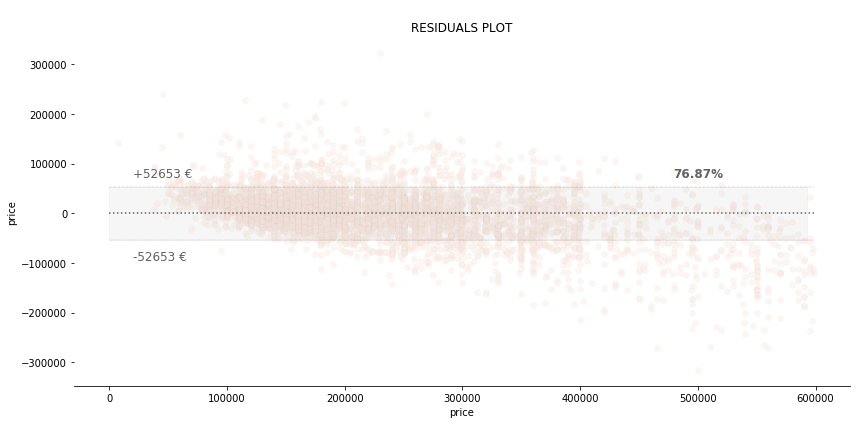

RMSE: 52653.7700970607
error: 22.16%
<±15k          30.76
±15k - ±30k    23.20
±30k - ±50k    20.93
±50k - ±75k    12.72
>±75k          12.39
Name: perc, dtype: float64


In [20]:
params = {
    'eval_metric': "rmse",
    'objective': "reg:squarederror",
    'seed': 89,
    'nthread':8,
    'n_estimators': 100,    
}

xgb_fit_pred(params, dtrain, dtest, y_test)

Vemos que el error es del 22.16&, con un 76,87% de los precios predichos dentro de un rango de +/- 52.653€ del precio real. Es decir, 3 de cada 4 predicciones no se alejan del precio real más de 52.653€.

A partir de ahora, nuestra meta será realizar una afinación de los parámetros con la que mejorar estos resultados.

### max_depth & n_estimators

El primer paso de la hiperparametrización será hallar la mejor combinación para el número y la profundidad de los árboles. Ambos parámetros están estrechamente relacionados, dado que, por lo general, a mayor profundidad, menor será el número de árboles necesario. Por ello, emplearemos una rejilla con distintas combinaciones para así descubrir cual parece ser la mejor opción.

No obstante, empezaremos por redefinir el resto de parámetros, los cuales se mantendran constantes para cada combinación de la rejilla:

In [56]:
upd = {
    'min_child_weight': 1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'gamma': 0,
    'reg_alpha': 0,
    'learning_rate': 0.1,
}
params.update(upd)

Y a continuación, empleamos la búsqueda por rejilla (*Grid Search*) con una serie de valores para los parámetros **max_depth** y **n_estimators**: 

In [ ]:
grid_p = {
 'n_estimators': [300,500,700],
 'max_depth': [6,8,10,12],
}
grid_labels = ['n_estimators','max_depth']

gsearch = grid_XGBRegressor(params, grid_p, X_train, y_train)
plot_grid_XGBRegressor(gsearch, grid_p, grid_labels)

Vemos que la mejor opción parece ser...


In [ ]:
grid_p = {
 'n_estimators': [400,500,600],
 'max_depth': [9,10,11],
}
grid_labels = ['n_estimators','max_depth']

gsearch = grid_XGBRegressor(params, grid_p, X_train, y_train)
plot_grid_XGBRegressor(gsearch, grid_p, grid_labels)

La mejor combinación es **n_estimators**=600 y **max_depth**=10. Por lo tanto, actualizamos nuestros parámetros con estos nuevos valores:

In [57]:
upd = {
    'n_estimators': 600,
    'max_depth': 10,
}
params.update(upd)

### min_child_weight

A continuación, trataremos de encontrar el valor de **min_child** que mejores resultados parezca ofrecer. Para ello, nuevamente, emplearemos una búsqueda por rejilla:

In [26]:
grid_p = {
 'min_child_weight': [1,2,3,4,5],
}
grid_labels = ['min_child_weight']

gsearch = grid_XGBRegressor(params, grid_p, X_train, y_train)
plot_grid_XGBRegressor(gsearch, grid_p, grid_labels)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  25 out of  25 | elapsed: 12.8min finished


Por último, actualizamos nuestros parámetros con el resultado obtenido:

In [58]:
upd = {
    'min_child_weight': 4,
}
params.update(upd)

### subsample & colsample_bytree

El próximo paso de nuestra hiperparametrización es la búsqueda de los mejores valores tanto para **subsample** como para **colsample_bytree**. Para ello, una vez más, nos valdremos de la búsqueda por rejilla:

In [30]:
grid_p = {
    'subsample': [0.4,0.6,0.8,1],
    'colsample_bytree': [0.2,0.4,0.6,0.8]
}
grid_labels = ['subsample','colsample_bytree']

gsearch = grid_XGBRegressor(params, grid_p, X_train, y_train)
plot_grid_XGBRegressor(gsearch, grid_p, grid_labels)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  6.9min
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed: 23.0min finished


Volvemos a generar otra rejilla para acotar más los valores:

In [32]:
grid_p = {
    'subsample': [0.7,0.75,0.8,0.85],
    'colsample_bytree': [0.35,0.4,0.45,0.5]
}
grid_labels = ['subsample','colsample_bytree']

gsearch = grid_XGBRegressor(params, grid_p, X_train, y_train)
plot_grid_XGBRegressor(gsearch, grid_p, grid_labels)

Fitting 5 folds for each of 16 candidates, totalling 80 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  34 tasks      | elapsed:  9.1min
[Parallel(n_jobs=8)]: Done  80 out of  80 | elapsed: 20.9min finished


Volvemos nuevamente a generar otra rejilla para hallar del todo los mejores valores:

In [34]:
grid_p = {
    'subsample': [0.82,0.85,0.87,0.9],
    'colsample_bytree': [0.4,0.45]
}
grid_labels = ['subsample','colsample_bytree']

gsearch = grid_XGBRegressor(params, grid_p, X_train, y_train)
plot_grid_XGBRegressor(gsearch, grid_p, grid_labels)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed:  9.7min finished


Una vez hemos encontrado los mejores valores, actualizamos nuestros parámetros:

In [59]:
upd = {
    'subsample': 0.87,
    'colsample_bytree':0.45,
}
params.update(upd)

### gamma & reg_alpha

Tras haber definido tanto el número como la profundidad y características de los árboles, así como el porcentaje de datos y columnas que emplearemos para cada uno de estos árboles, el siguiente paso es ajustar los parámetros de regularización.

Para ello, nuevamente, nos valdremos de la búsqueda de rejilla para hallar, primero los mejores valores para **gamma**, y luego para  **reg_alpha**:

In [37]:
grid_p = {
 'gamma': [0,1e-5,1e-3,0.05,0.1,0.5,1,10],
}
grid_labels = ['gamma']

gsearch = grid_XGBRegressor(params, grid_p, X_train, y_train)
plot_grid_XGBRegressor(gsearch, grid_p, grid_labels)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed: 10.3min finished


A continuación, hacemos lo propio con **reg_alpha**:

Fitting 5 folds for each of 8 candidates, totalling 40 fits


[Parallel(n_jobs=8)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  40 out of  40 | elapsed: 11.0min finished


Los mejores parametros son: {'reg_alpha': 1}



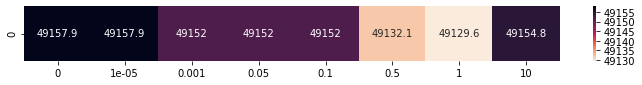

In [39]:
grid_p = {
 'reg_alpha': [0,1e-5,1e-3,0.05,0.1,0.5,1,10],
}
grid_labels = ['reg_alpha']

gsearch = grid_XGBRegressor(params, grid_p, X_train, y_train)
plot_grid_XGBRegressor(gsearch, grid_p, grid_labels)

Finalmente, actualizamos los valores:

In [60]:
upd = {
    'gamma': 0,
    'reg_alpha':1,
}
params.update(upd)

### learning_rate & n_estimators

Una vez hemos seleccionado los valores para los distintos parámetros, el último paso será disminuir el valor de **learning_rate**, con lo cual, conseguiremos una afinación más precisa que, previsiblemente, haga que las predicciones sean más certeras.

No obstante, el escoger un **learning_rate** inferior acarreará que tengamos que escoger un nuevo número de árboles, ya que de mantener el que teníamos hasta ahora, no acabaría de convergería lo suficiente (necesitará muchos más).

Por otro lado, cabe recordar que los hiperparámetros que hemos ido seleccionando no son del todo independientes. Por lo tanto, el seleccionar nuevos valores tanto para **learning rate** como para **n_estimators**, probablemente, genere que la selección que hemos llevado a cabo en los pasos previos, si bien seguirá siendo buena, quizás ya no sea los óptima. Sin embargo, la búsqueda de hiperparámetros con un nivel tan bajo de **learning_rate** hubiera supuesto tiempos de entrenamiento demasiado elevados:

Por lo tanto, nos limitaremos a mantener los parámetros seleccionados en los pasos previos, excepto el número de árboles, que lo actualizaremos valíendonos de **early_stopping_rounds**: 

In [44]:
upd = {
    'learning_rate': 0.01,
    'n_estimators': 20000,
}
params.update(upd)

get_n_estimators(params, dtrain, verbose=False, early_stopping_rounds=150, cv_folds=5)

"n_estimators": 4910
      train-rmse-mean  train-rmse-std  test-rmse-mean  test-rmse-std
4909     26020.265234      209.427808    49133.994531     979.471205


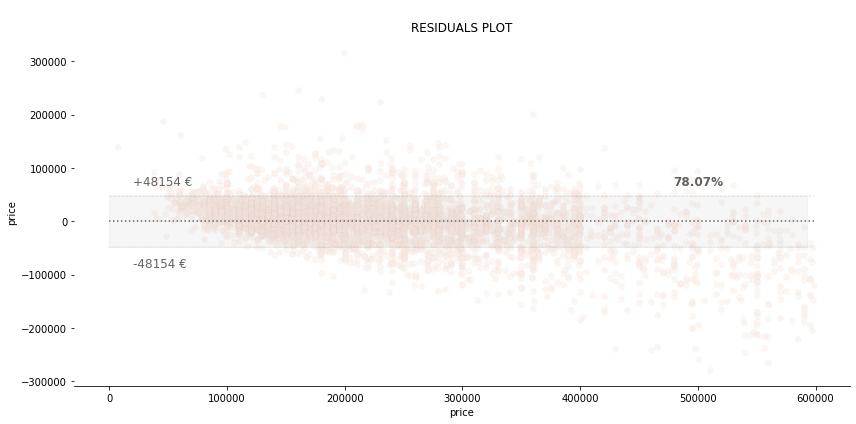

RMSE: 48154.42203890655
error: 20.27%
<±15k          35.21
±15k - ±30k    25.42
±30k - ±50k    18.62
±50k - ±75k    10.77
>±75k           9.98
Name: perc, dtype: float64


In [61]:
upd = {
    'n_estimators': 4910
}
params.update(upd)

xgb_model = xgb_fit_pred(params, dtrain, dtest, y_test)

Por último, podemos comprobar cuáles son las variables mas importantes a la hora de predecir los precios de las viviendas, utilizando para ello los **F-Score**:

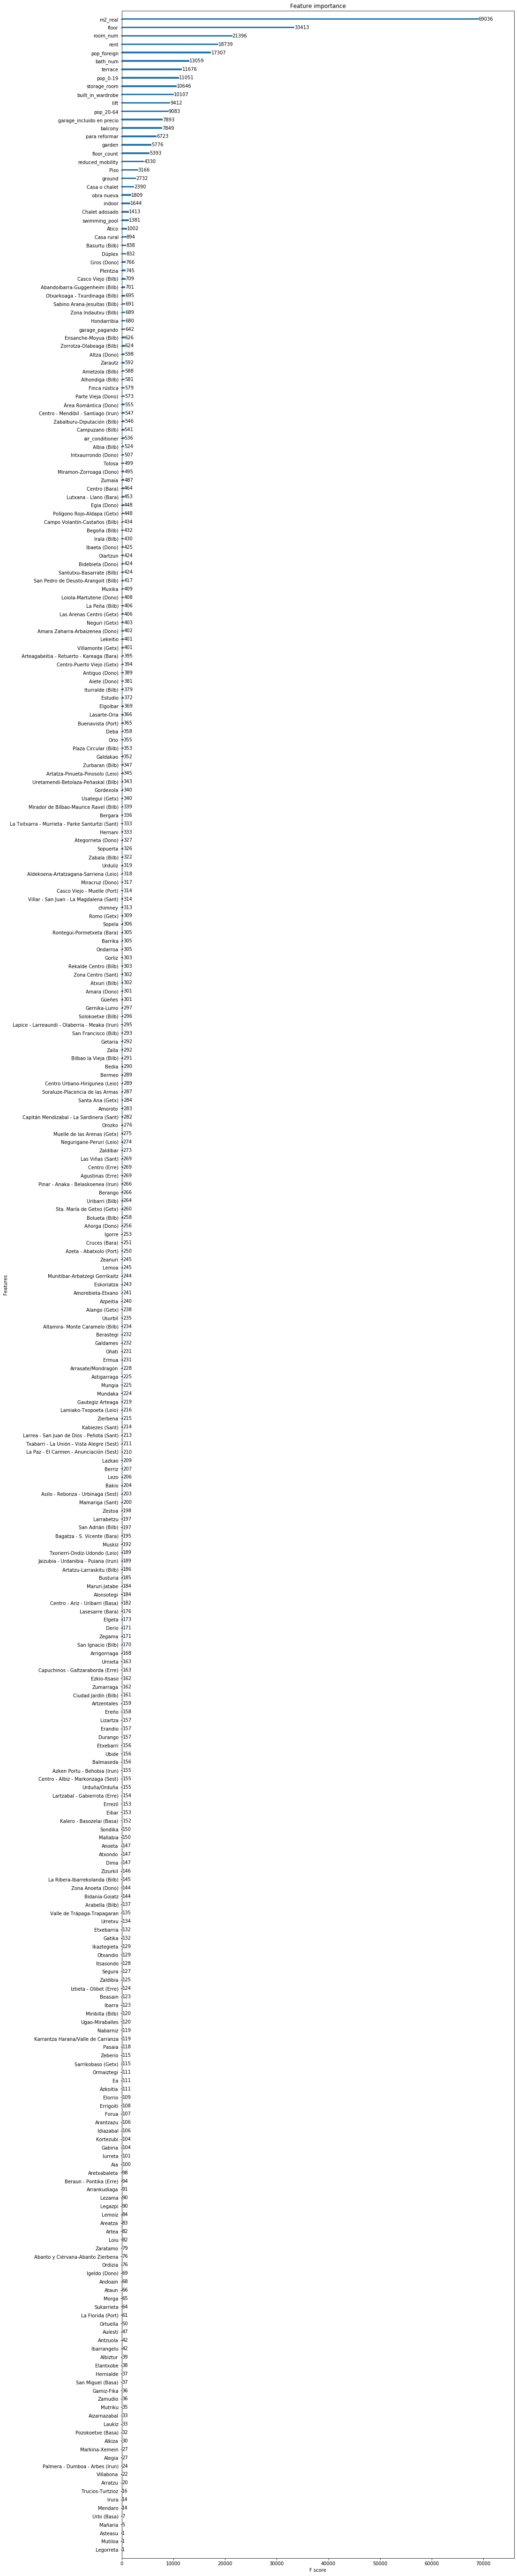

In [62]:
f, ax = plt.subplots(figsize=(15,100))

xgb.plot_importance(xgb_model, grid=False, ax=ax);

In [ ]:
plt.figure(figsize=(14, 10))
x_points=np.arange(1,4001,1)

#sns.lineplot(x=x_points, y=cvresult['test-rmse-mean'], color='r');
#sns.lineplot(x=x_points, y=cvresult['train-rmse-mean']);